# PIPELINE

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np 
import os

from vip_hci.fits import open_fits
from main import (shift_and_crop_cube, 
                  frame_center, 
                  get_square, 
                  fit_gaussian_2d, 
                  recenter_cube, 
                  normalize_psf)
from pca import reduce_pca
from detection import get_intersting_coords
from loss import inject_fcs_cube_mod

%load_ext autoreload
%autoreload 2

In [2]:
# root = '../yems/exomoons/Data_set_DHTau'
root = './data/HCI'
cube_route = os.path.join(root, 'center_im.fits')
psf_route  = os.path.join(root, 'median_unsat.fits')
ra_route   = os.path.join(root, 'rotnth.fits')
lam_route  = os.path.join(root, 'lam.fits')

lambda_ch = 0
psf_pos   = 0

## LOADING DATA

In [3]:
cube        = open_fits(cube_route, header=False) 
psf         = open_fits(psf_route, header=False)
rot_angles  = open_fits(ra_route, header=False)
rot_angles  = -rot_angles
try:
    lambdas_inf = open_fits(lam_route, header=False)
except:
    pass
cube.shape, psf.shape

Fits HDU-0 data successfully loaded. Data shape: (2, 90, 201, 201)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (90,)
Fits HDU-0 data successfully loaded. Data shape: (2,)


((2, 90, 201, 201), (2, 2, 64, 64))

## Check if even image size

In [4]:
if cube.shape[-1] % 2 == 0:
    cube = shift_and_crop_cube(cube[lambda_ch], n_jobs=4)
    
if psf.shape[-1] % 2 == 0:
    psf = shift_and_crop_cube(psf[lambda_ch], n_jobs=4)
    print(psf.shape)

New shape: (2, 63, 63)
(2, 63, 63)


In [5]:
ceny, cenx = frame_center(psf[psf_pos])
imside = psf[psf_pos].shape[0]
cropsize = 30

### STANDARDIZE PSF 

In [6]:
psf_subimage, suby, subx = get_square(psf[psf_pos], 
                                      min(cropsize, imside),
                                      ceny, cenx, 
                                      position=True, 
                                      verbose=False)

In [7]:
fwhm_y, fwhm_x, mean_y, mean_x = fit_gaussian_2d(psf_subimage)

mean_y +=  suby # put the subimage in the original center
mean_x +=  subx # put the subimage in the original center

fwhm_sphere  = np.mean([fwhm_y, fwhm_x]) # Shared across the frames 

In [8]:
psf.shape

(2, 63, 63)

In [9]:
psf_rec = recenter_cube(psf, psf[psf_pos], fwhm_sphere=fwhm_sphere, n_jobs=4)
print(psf_rec.shape)

(2, 63, 63)


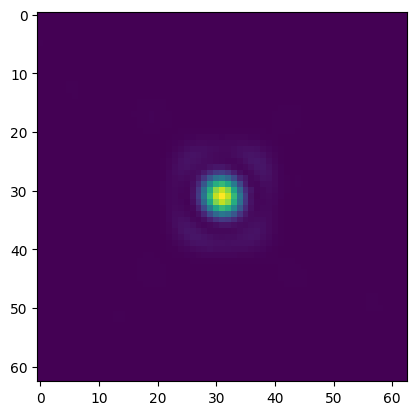

In [10]:
psf_norm, fwhm_flux, fwhm = normalize_psf(psf_rec[psf_pos], fwhm=fwhm_sphere, full_output=True, verbose=False)

plt.figure()
plt.imshow(psf_norm)
plt.show()

## Angular Differential Imaging (ADI)

In [11]:
from pca import reduce_pca_opt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%%time
if len(cube.shape) > 3:
    cube_pca = cube[lambda_ch]
else:
    cube_pca = cube
    
frame_pca, res_cube = reduce_pca(cube_pca, rot_angles, ncomp=1, 
                             fwhm=4, return_cube=True, 
                             plot=False, dpi=100, n_jobs=8)


# frame_pca, res_cube = reduce_pca_opt(cube_pca, rot_angles, ncomp=1, 
#                              fwhm=4, return_cube=True, 
#                              plot=False, dpi=100, n_jobs=8)

CPU times: user 1.08 s, sys: 170 ms, total: 1.25 s
Wall time: 448 ms


## Detection

In [13]:
table = get_intersting_coords(frame_pca, psf_norm, fwhm=fwhm, bkg_sigma=5)
table = table[table['snr'] > 2.]
print(table)

           x          y      flux  fwhm_mean       snr
0  90.673543  87.139237  3.873217    3.99179  2.582123


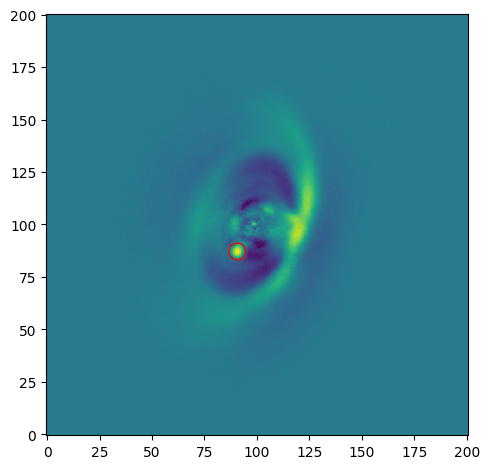

In [59]:
fig, ax = plt.subplots(1,1, dpi=100)
ax.imshow(frame_pca, origin="lower")
for _, row in table.iterrows():
    circle = plt.Circle((row['x'], row['y']), row['fwhm_mean'], fill=False, edgecolor='r')  
    ax.add_patch(circle)
fig.tight_layout()
plt.show()

In [60]:
init_values = table.iloc[0].values[:3]
init_values = [init_values[1], init_values[0], init_values[2]]
init_values

[87.13923685208721, 90.67354259556207, 3.873217251043832]

In [61]:
from vip_hci.fm.negfc_mcmc import mcmc_negfc_sampling

Speed tricks:
- set ``imlib='opencv'`` (much faster image rotations, BUT at the expense
  of flux conservation);
- increase ``nproc`` (if your machine allows);
- reduce ``ac_c`` (or increase ``rhat_threshold`` if ``conv_test='gb'``) 
  for a faster convergence);
- reduce ``niteration_limit`` to force the sampler to stop even if it 
  has not reached convergence.

## Crop and mask cube 

In [62]:
from plottools import create_circular_mask

In [63]:
if len(cube.shape) <= 3:
    cube = cube[None, :]

In [64]:
ceny, cenx = frame_center(cube[0, 0])
imside = cube[0, 0].shape[0]
try:
    lambda_val = lambdas_inf[0]
except:
    lambda_val = 3
    
cropsize = int(lambda_val*30)

cube_crop = []
mask_crop = []
for frame in cube[0]:
    sub_im, suby, subx = get_square(frame[1:, 1:], 
                                    min(cropsize, imside),
                                    ceny, cenx, 
                                    position=True, 
                                    verbose=False)
    w, h = sub_im.shape
    sub_mask = create_circular_mask(h=h, w=w,
                                    center=frame_center(sub_im), 
                                    radius=3*lambda_val)
    
    cube_crop.append(sub_im)
    mask_crop.append(1.-sub_mask)
    
cube_crop = np.array(cube_crop)
mask_crop = np.array(mask_crop)

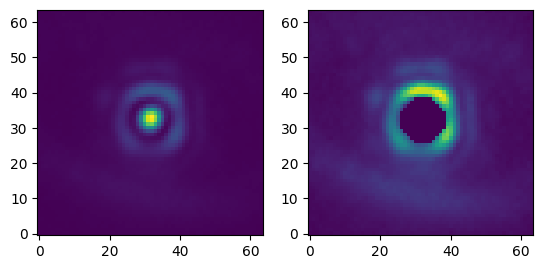

In [65]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cube_crop[0],  origin="lower")
axes[1].imshow(cube_crop[0]*mask_crop[0],  origin="lower")

We adjust the initial values to be consistent with the cropped image

In [66]:
init_values_crop = [init_values[0]- suby, init_values[1]- subx, init_values[2]]

In [67]:
np.min(psf_norm), np.max(psf_norm)

(-5.346229345750824e-05, 0.06817923814387175)

In [ ]:
%%time
mcmc_output = mcmc_negfc_sampling(cube_crop, 
                                  rot_angles, 
                                  psf_norm, 
                                  init_values_crop, 
                                  imlib='opencv',
                                  niteration_limit=1000,
                                  nwalkers=100,
                                  nproc=8)

We should decide from what iteration the sampler converge to the real distribution 

In [112]:
mcmc_output.shape

(100, 100, 3)

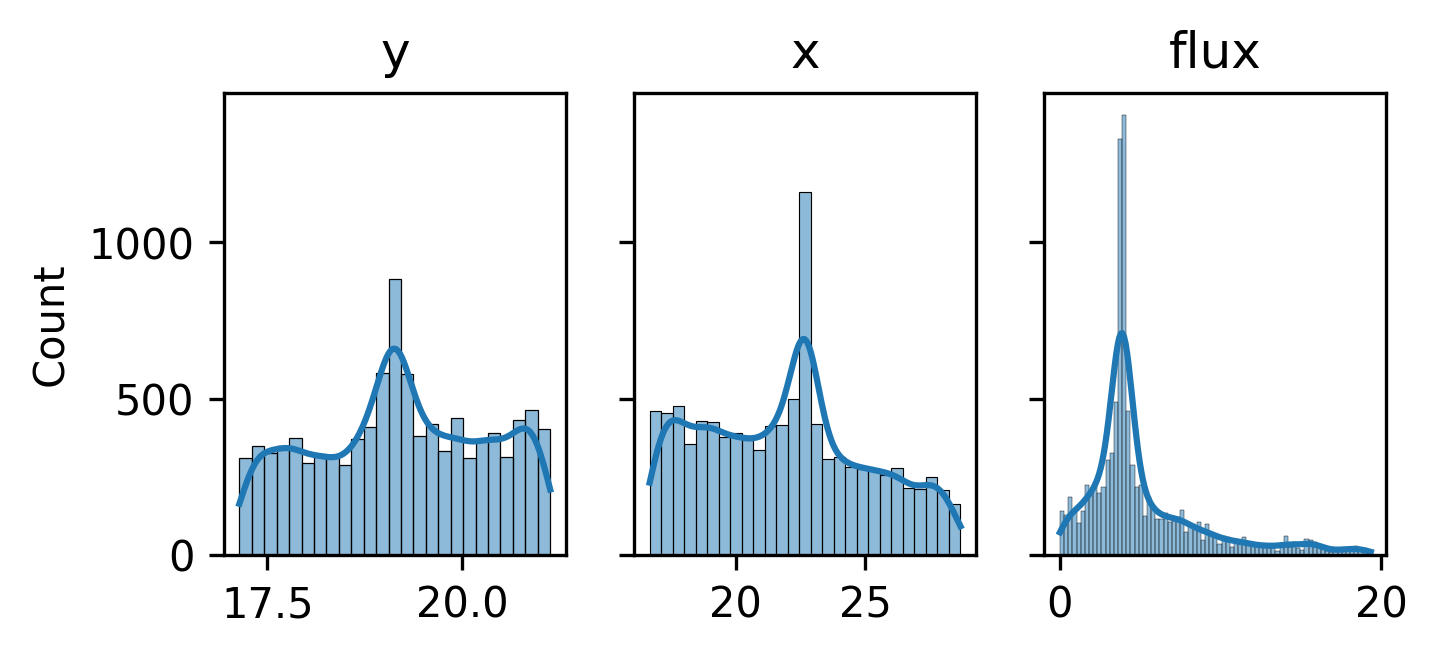

In [113]:
### selected_out = mcmc_output[:, 9:, :]
out_size = mcmc_output.shape
out = np.reshape(mcmc_output, [out_size[0]*out_size[1], out_size[2]])

fig, axes = plt.subplots(1,3, figsize=(5,2), sharey=True, dpi=300)

name_params = ['y', 'x', 'flux']
for index, ax in enumerate(axes.flatten()):
    sns.histplot(out[:, index], ax=ax, kde=True)
    ax.set_title(name_params[index])

plt.show()




Now we are going to use the final values to inject a fake companion and use PCA visualize if the companion was deleted

In [114]:
y_star, x_star, flux_star = np.mean(np.mean(mcmc_output, axis=0), axis=0)
print(init_values_crop[-1], flux_star)

x_star = init_values_crop[0]
y_star = init_values_crop[1]
# flux_star = init_values_crop[2]

y_star += suby # go back to the original dimension 
x_star += subx # go back to the original dimension

3.873217251043832 5.187831122363999


In [115]:
x_cube_center, y_cube_center = frame_center(cube[0])
x = float(x_star) - x_cube_center
y = float(y_star) - y_cube_center
radius = np.sqrt(x**2+y**2) # radius
angle  = np.arctan2(x, y)   # radians
angle  = angle/np.pi*180    # degrees
# Since atan2 return angles in between [0, 180] and [-180, 0],
# we convert the angle to refers a system of 360 degrees
theta = np.mod(angle, 360) 

In [116]:
from vip_hci.fm.fakecomp import cube_inject_companions
frame_fake = cube_inject_companions(cube[0], psf_norm, rot_angles, -flux_star*30, radius,
                                    plsc=None, n_branches=1, theta=theta, imlib='vip-fft',
                                    interpolation='lanczos4', transmission=None,
                                    radial_gradient=False, full_output=False,
                                    verbose=False, nproc=1)

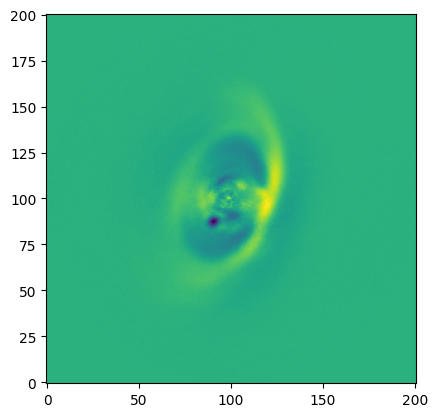

In [117]:
frame_2, res_cube = reduce_pca(frame_fake, 
                               rot_angles, 
                               ncomp=1, 
                               fwhm=4, 
                               return_cube=True, 
                               n_jobs=8)

plt.imshow(frame_2, origin='lower')

In [118]:
# negfc_cube = []
# for i, frame in enumerate(cube[0]):
#     blank = np.zeros_like(frame)
#     radius = np.sqrt(x**2+y**2) # radius
#     angle  = np.arctan2(x, y)   # radians
#     angle  = angle/np.pi*180    # degrees
#     # Since atan2 return angles in between [0, 180] and [-180, 0],
#     # we convert the angle to refers a system of 360 degrees
#     theta = np.mod(angle, 360) 
#     params = (radius, theta, flux_star)
            
#     frame_negfc = inject_fcs_cube_mod(blank, 
#                                   psf_norm, 
#                                   rot_angles[i], 
#                                   flux_star, 
#                                   radius, 
#                                   theta, 
#                                   n_branches=1)   
    
#     plt.imshow(frame-frame_negfc, origin='lower')
#     plt.imshow(frame, origin='lower', alpha=.8)

#     negfc_cube.append(frame_negfc)
# negfc_cube = np.array(negfc_cube)
# negfc_cube.shape

In [119]:
# fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, dpi=300)

# for i, ax in enumerate(axes.flatten()):
#     ax.imshow(negfc_cube[i])
    
# plt.show()

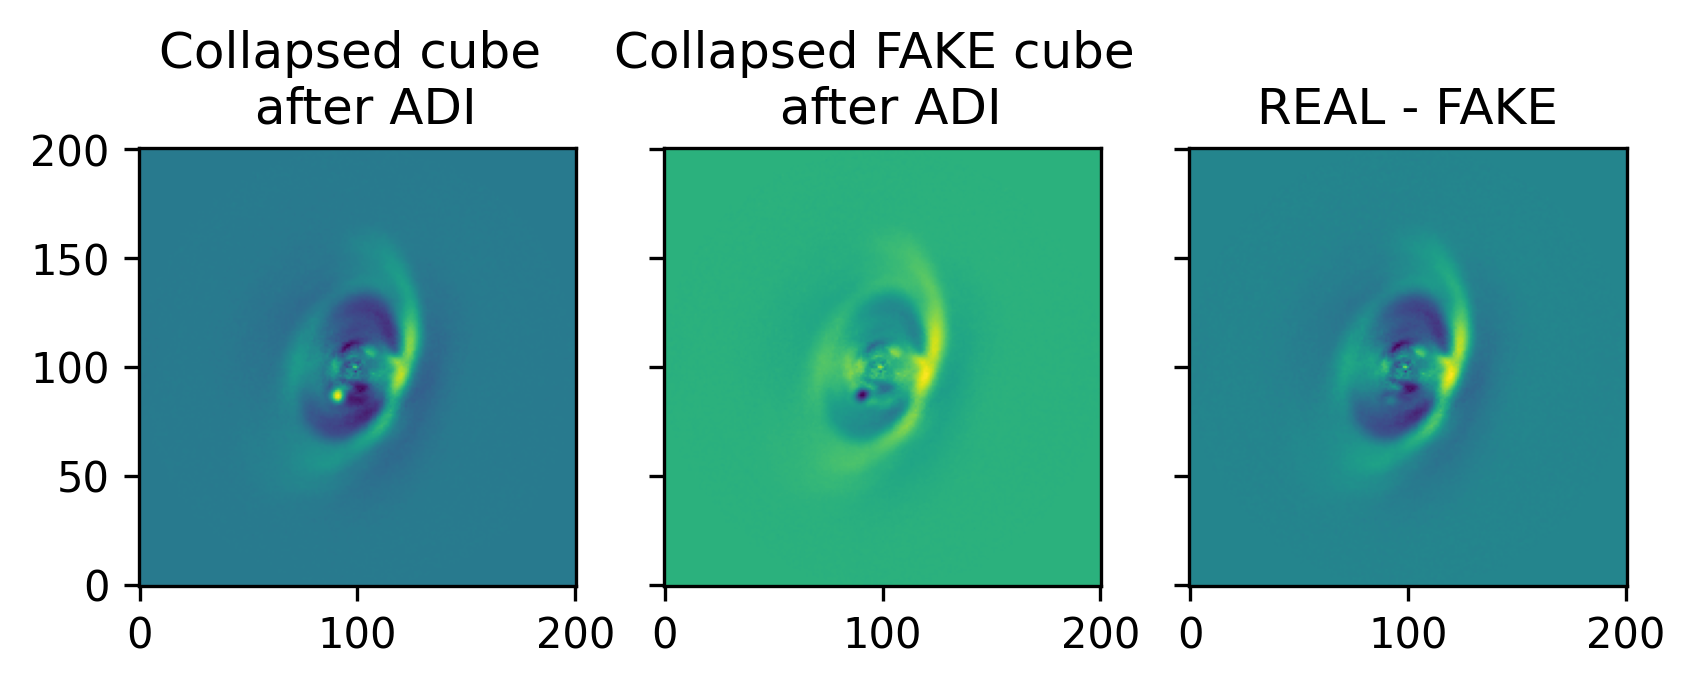

In [120]:
fig, axes = plt.subplots(1, 3, dpi=300, sharex=True, sharey=True)
axes[0].imshow(frame_pca, origin = "lower", label='original')
axes[0].set_title('Collapsed cube \n after ADI')
axes[1].imshow(frame_2, origin = "lower", label='negfc_pca')
axes[1].set_title('Collapsed FAKE cube \n after ADI')
axes[2].imshow(frame_pca+frame_2, origin = "lower", label='residuals')
axes[2].set_title('REAL - FAKE')
plt.show()

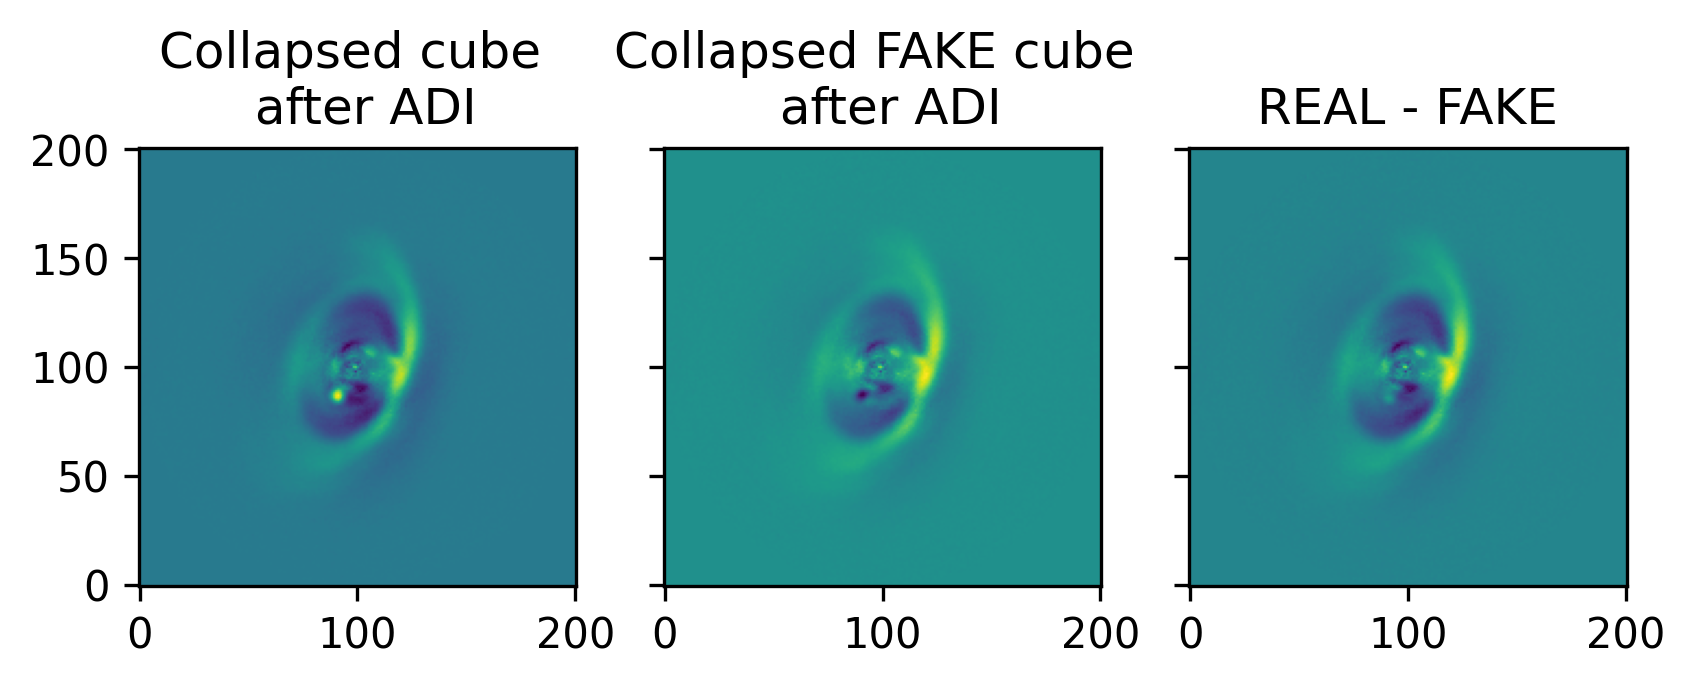

In [103]:
fig, axes = plt.subplots(1, 3, dpi=300, sharex=True, sharey=True)
axes[0].imshow(frame_pca, origin = "lower", label='original')
axes[0].set_title('Collapsed cube \n after ADI')
axes[1].imshow(frame_2, origin = "lower", label='negfc_pca')
axes[1].set_title('Collapsed FAKE cube \n after ADI')
axes[2].imshow(frame_pca+frame_2, origin = "lower", label='residuals')
axes[2].set_title('REAL - FAKE')
plt.show()